#  The objective of this data analysis is to determine the number of patients who came to the clinic; determine various trends; and provide recommendations.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from scipy.stats import chi2_contingency
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from urllib.request import urlretrieve

In [3]:
url = 'https://raw.githubusercontent.com/boltboihatesbananas/STI_Clinic/main/Data/clean_clinic_data.csv'


df = pd.read_csv(url, index_col=0)
print(df.head(5), "\n\n")
print(df.shape)

  PatientNumber Sex  International Student (reg file)         Ethnicity  \
0      Patient1   M                                 0             Asian   
1      Patient1   M                                 0             Asian   
2      Patient1   M                                 0             Asian   
3      Patient1   M                                 0             Asian   
4     Patient10   F                                 0  Caucasian, White   

                           School Academic Class NCAA       CollectionDate  \
0                 Wharton Masters              G  NaN  2023-01-10 00:00:00   
1                 Wharton Masters              G  NaN  2023-01-10 00:00:00   
2                 Wharton Masters              G  NaN  2023-02-23 15:20:00   
3                 Wharton Masters              G  NaN  2023-02-23 15:20:00   
4  School Policy Practice Masters              G  NaN  2023-01-19 10:04:00   

                                     TestName        Result        School_v2  \


In [9]:
positive_tests = df[df['Result'] == 'DETECTED']

print("The number of unique individuals over the semester:", df['PatientNumber'].nunique())
print("\nThe number of unique visits over the semester:", df.groupby(['PatientNumber', 'Date']).nunique().count().values[0])
print("\nThe number of positive results:", df[df['Result'] == 'DETECTED'].count().values[0])
print("\nThe number of unique patients with positive tests over the semester:", df[df['Result'] == 'DETECTED'].groupby(['PatientNumber']).nunique().count().values[0])
print("\nThe positive tests were broken down by:", positive_tests['Sex'].value_counts())
print("\nThe positive tests were broken down by:", positive_tests['Academic Class'].value_counts())
print("\nThe positive tests were broken down by:", positive_tests['School_v2'].value_counts())
print("\nThe positive tests were broken down by:", positive_tests.groupby(["Academic Class", "School_v2"])
                                                              .size()
                                                              .reset_index(name='Count')
                                                              .sort_values(by=['Academic Class', 'Count'], ascending=[True, False]))
print("\nThe positive tests were broken down by:", positive_tests['International Student (reg file)'].value_counts())
print("\nThe positive tests were broken down by:", positive_tests['NCAA'].value_counts())

The number of unique individuals over the semester: 1500

The number of unique visits over the semester: 1771

The number of positive results: 67

The number of unique patients with positive tests over the semester: 59

The positive tests were broken down by: Sex
M    40
F    27
Name: count, dtype: int64

The positive tests were broken down by: Academic Class
G    41
U    26
Name: count, dtype: int64

The positive tests were broken down by: School_v2
Arts and Sciences    20
Wharton              17
Education             8
Nursing               5
Medical               5
Engineering           5
Dental                3
Policy Practice       2
LPS                   2
Name: count, dtype: int64

The positive tests were broken down by:    Academic Class          School_v2  Count
7               G            Wharton     14
2               G          Education      8
3               G        Engineering      5
5               G            Medical      5
1               G             Dental      

#### To control for different school sizes we will find the numbers of students in each program to find a rate of clinic use.

In [24]:
male, u_male, g_male = 11892, 4569, 7323
female, u_female, g_female = 14948, 5320, 9628
undergrad_total, grad_total = u_male + u_female, g_male + g_female

u_arts_sciences, u_wharton, u_engineering, u_nursing = 7135, 1758, 1777, 580
g_arts_sciences, g_wharton, g_engineering, g_education, g_law, g_nursing, g_dental, g_medicine, g_design, g_veterinary, g_policy_practice, g_communications = 2168, 2398, 4140, 1664, 993, 607, 789, 2122, 768, 571, 663, 68


In [96]:
# Splitting the DataFrame based on 'Academic Class'
grad_clinic = result[result['Academic Class'] == 'G']
undergrad_clinic = result[result['Academic Class'] == 'U']

grad_clinic_result = grad_clinic.value_counts()
undergrad_clinic_result = undergrad_clinic.value_counts()

grad_clinic_result_df = grad_clinic_result.reset_index()
undergrad_clinic_result_df = undergrad_clinic_result.reset_index()

grad_clinic_result_df = grad_clinic_result_df.loc[:, ['School_v2', 'Count']]
undergrad_clinic_result_df = undergrad_clinic_result_df.loc[:, ['School_v2', 'Count']]




           School_v2  Count
0  Arts and Sciences      2
1             Dental      3
2          Education      8
3        Engineering      5
4                LPS      2
5            Medical      5
6    Policy Practice      2
7            Wharton     14


In [106]:
# Calculate rates for each school in grad_clinic_result
rates_grad = {}
for _, row in grad_clinic_result_df.iterrows():
    school = row['School_v2']
    count = row['Count']
        
    if school == 'Wharton':
        rates_grad[school] = count / g_wharton * 100
    elif school == 'Education':
        rates_grad[school] = count / g_education * 100
    elif school == 'Engineering':
        rates_grad[school] = count / g_engineering * 100
    elif school == 'Medical':
        rates_grad[school] = count / g_medicine * 100 
    elif school == 'Dental':
        rates[school] = count / g_dental * 100 
    elif school == 'Arts and Sciences':
        rates_grad[school] = count / g_arts_sciences * 100 
    elif school == 'Policy Practice':
        rates_grad[school] = count / g_policy_practice * 100 

# Display rates for graduate schools
print("For graduate school:\n")
for school, rate in rates_grad.items(): 
    print(f'{school}: {rate:.2f} per 100 students')


For graduate school:

Arts and Sciences: 0.09 per 100 students
Education: 0.48 per 100 students
Engineering: 0.12 per 100 students
Medical: 0.24 per 100 students
Policy Practice: 0.30 per 100 students
Wharton: 0.58 per 100 students


In [105]:
# Calculate rates for each school in grad_clinic_result
rates_undergrad = {}
for _, row in undergrad_clinic_result_df.iterrows():
    school = row['School_v2']
    count = row['Count']
        
    if school == 'Arts and Sciences':
        rates_undergrad[school] = count / u_arts_sciences * 100
    elif school == 'Nursing':
        rates_undergrad[school] = count / g_nursing * 100
    elif school == 'Wharton':
        rates_undergrad[school] = count / g_wharton * 100


# Display rates for graduate schools
print("For graduate school:\n")
for school, rate in rates_undergrad.items(): 
    print(f'{school}: {rate:.2f} per 100 students')


For graduate school:

Arts and Sciences: 0.25 per 100 students
Nursing: 0.82 per 100 students
Wharton: 0.13 per 100 students


Length of schools list: 6
Length of rate_values list: 6


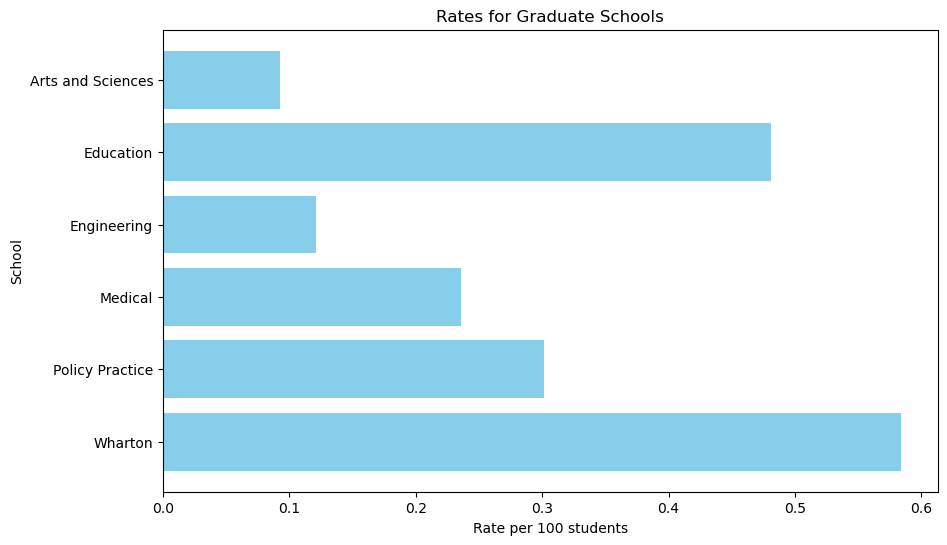

Length of schools list: 3
Length of rate_values list: 3


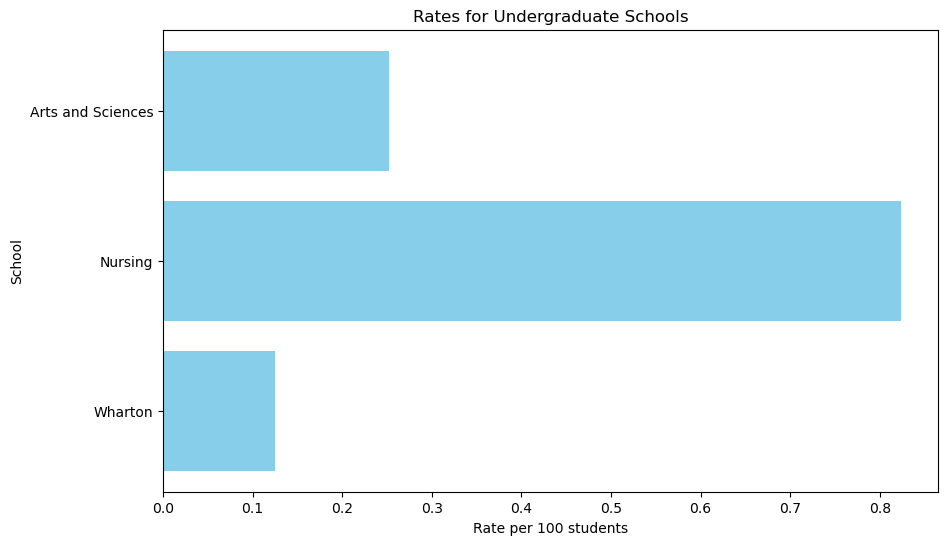

#### Lets take a look at the usage of the clinic

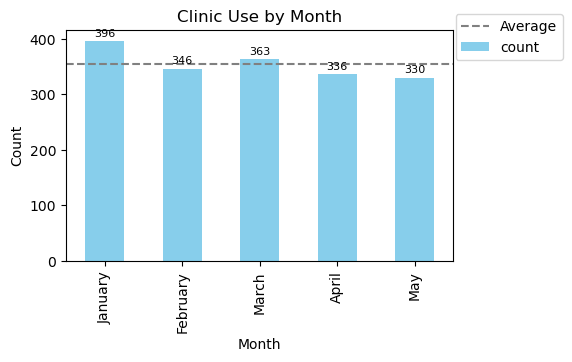

In [114]:
unique_visits = df.drop_duplicates(subset=['PatientNumber', 'Date'])
unique_visits.shape



month_order = ['January', 'February', 'March', 'April', 'May']

unique_visits = unique_visits.copy()

unique_visits['Month'] = unique_visits['Month'].map({1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May'})
unique_visits['Month'] = pd.Categorical(unique_visits['Month'], categories=month_order, ordered=True)

unique_visits = unique_visits.sort_values(by='Month').reset_index(drop=True)  # Resetting the index to avoid issues

average_value = unique_visits['Month'].value_counts().mean()

plt.figure(figsize=(5, 3))
bar_plot = unique_visits['Month'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.axhline(y=average_value, color='gray', linestyle='--', label='Average')  # Add average line

for index, value in enumerate(unique_visits['Month'].value_counts().sort_index()):
    bar_plot.text(index, value + 5, str(value), ha='center', va='bottom', fontsize=8)

plt.title("Clinic Use by Month")
plt.xlabel("Month")
plt.ylabel("Count")
plt.legend(loc='upper right',bbox_to_anchor=(1.3,1.1))
plt.show()

In [ ]:
# Assuming 'Day' is the column in your DataFrame
# Replace it with the actual column name from your DataFrame
days_to_remove = ['Sunday', 'Saturday']

# Create a copy of the DataFrame
unique_visits_day = unique_visits.copy()

# Filter out Sunday and Saturday
unique_visits_day = unique_visits_day[~unique_visits_day['Day'].isin(days_to_remove)]

# Sort the DataFrame by the 'Day' column
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
unique_visits_day['Day'] = pd.Categorical(unique_visits_day['Day'], categories=day_order, ordered=True)
unique_visits_day = unique_visits_day.sort_values(by='Day').reset_index(drop=True)

# Calculate average value
average_value_day = unique_visits_day['Day'].value_counts().mean()

# Plotting
plt.figure(figsize=(10, 6))
bar_plot_day = unique_visits_day['Day'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.axhline(y=average_value_day, color='gray', linestyle='--', label='Average')  # Add average line

# Add values to the bar chart
for index, value in enumerate(unique_visits_day['Day'].value_counts().sort_index()):
    bar_plot_day.text(index, value + 5, str(value), ha='center', va='bottom', fontsize=8)

plt.title("Clinic Use by Day (Excluding Saturday and Sunday)")
plt.xlabel("Day")
plt.ylabel("Count")
plt.legend()
plt.show()

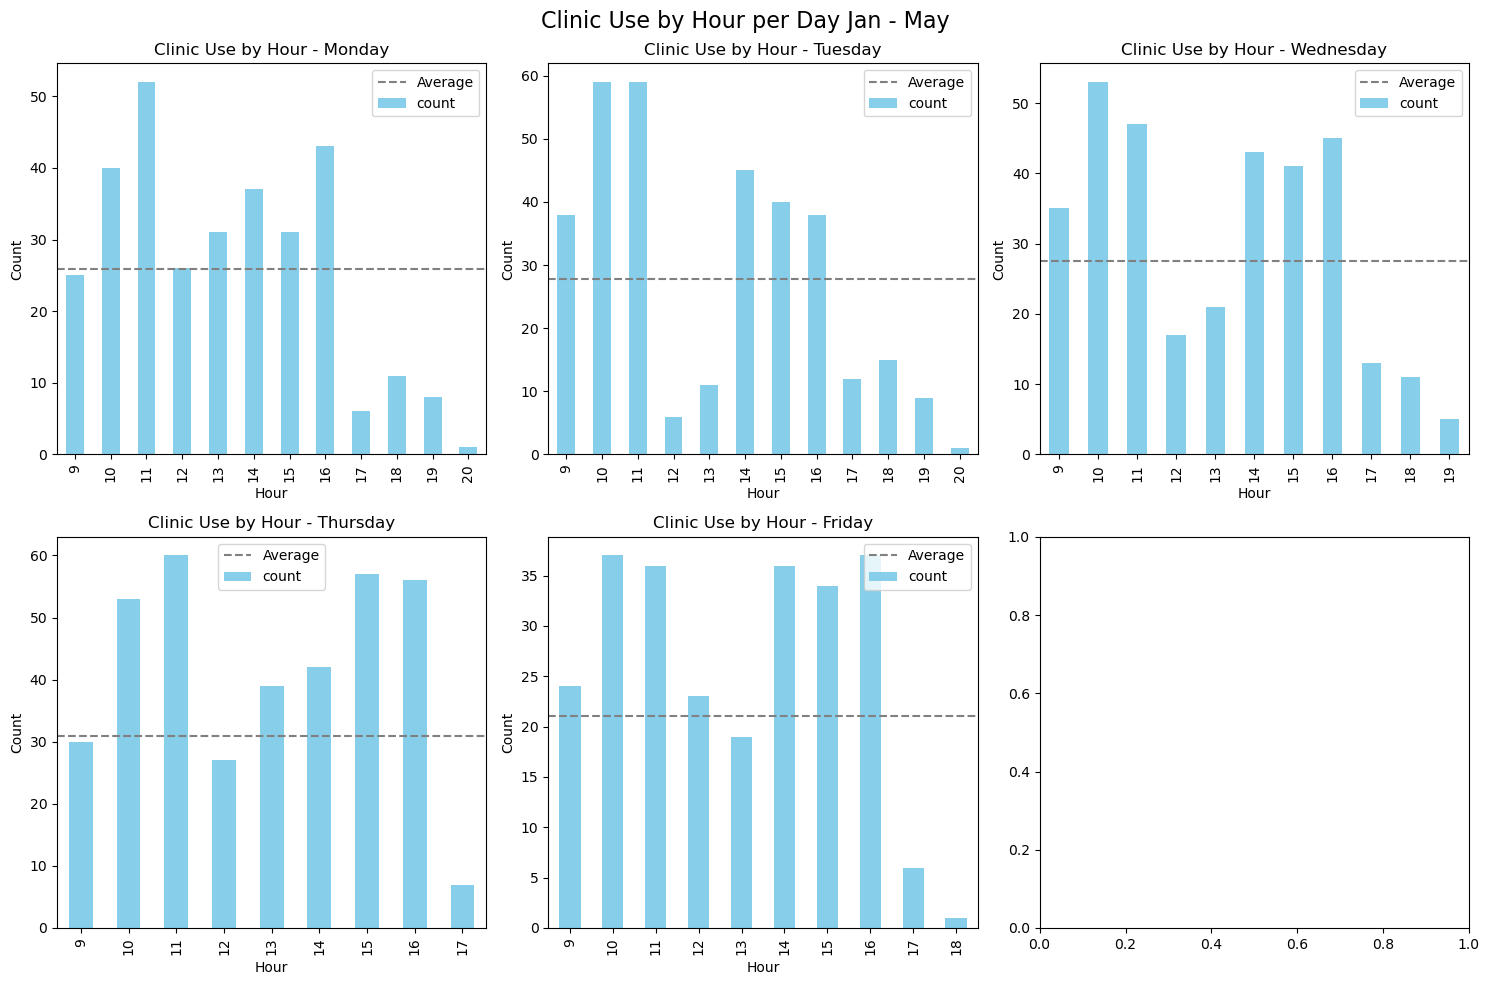

In [107]:
days_to_exclude = ['Saturday', 'Sunday']
hours_to_exclude = list(range(9))  # Hours 0 to 8

unique_visits_hour = unique_visits.copy()

unique_visits_hour = unique_visits_hour[~unique_visits_hour['Day'].isin(days_to_exclude)]

unique_visits_hour = unique_visits_hour[~unique_visits_hour['Hour'].isin(hours_to_exclude)]

day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
unique_visits_hour['Day'] = pd.Categorical(unique_visits_hour['Day'], categories=day_order, ordered=True)
unique_visits_hour = unique_visits_hour.sort_values(by=['Day', 'Hour']).reset_index(drop=True)

average_values_day = unique_visits_hour.groupby('Day')['Hour'].value_counts().groupby('Day').mean()

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

for i, day in enumerate(day_order):
    ax = axes[i // 3, i % 3]
    
    data_day = unique_visits_hour[unique_visits_hour['Day'] == day]
    
    average_value_day = average_values_day[day]
    
    bar_plot_hour = data_day['Hour'].value_counts().sort_index().plot(kind='bar', ax=ax, color='skyblue')
    ax.axhline(y=average_value_day, color='gray', linestyle='--', label='Average')  # Add average line
    
    ax.set_title(f"Clinic Use by Hour - {day}")
    ax.set_xlabel("Hour")
    ax.set_ylabel("Count")
    ax.legend()

plt.subplots_adjust(top=2.5)
fig.suptitle('Clinic Use by Hour per Day Jan - May', fontsize=16)
    
    
plt.tight_layout()
plt.show()


In [ ]:
undergrad_school_counts = df[df["Academic Class"] == 'U']["School_v2"].value_counts()
grad_school_counts = df[df["Academic Class"] == 'G']["School_v2"].value_counts()

# Combine the counts into a single DataFrame
combined_counts = pd.DataFrame({
    'Undergrad': undergrad_school_counts,
    'Grad': grad_school_counts
}).fillna(0)

# Plotting
combined_counts.plot(kind='bar', width=0.8, figsize=(10, 6))
plt.title("Undergrad vs Grad count")
plt.xlabel("School Category")
plt.ylabel("Count")
plt.legend(title="Academic Class")
plt.show()

Day
Thursday     397
Tuesday      358
Wednesday    358
Monday       347
Friday       278
Saturday      32
Sunday         1
Name: count, dtype: int64